In [1]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import random
import os
import tensorflow as tf

In [2]:
from keras.models import Sequential
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, GlobalMaxPooling2D
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.applications import VGG16
from keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

In [12]:
METRICS = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall'),
           tf.keras.metrics.AUC(name='auc')]

In [13]:
IMAGE_SIZE = 48
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

num_epochs = 60
batch_size = 64

pre_trained_model = VGG16(input_shape=INPUT_SHAPE, include_top=False, weights='imagenet')

for layer in pre_trained_model.layers[:20]:
    layer.trainable = False

for layer in pre_trained_model.layers[20:]:
    layer.trainable = True
    
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
    
x = GlobalMaxPooling2D()(last_output)

x = Dense(512, activation='relu')(x)

x = Dropout(0.5)(x)

x = layers.Dense(7, activation='softmax')(x)

model = Model(pre_trained_model.input, x)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=0.0001),
              metrics=METRICS)

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0   

In [14]:
train_datagen = ImageDataGenerator(rotation_range=5,
                                   rescale=1./255,
                                   validation_split=0.2,
                                   shear_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.2)

In [15]:
train_dataset = train_datagen.flow_from_directory(directory='../data/train',
                                                  target_size=(48,48),
                                                  class_mode='categorical',
                                                  subset='training',
                                                  batch_size=64)

valid_dataset = valid_datagen.flow_from_directory(directory='../data/train',
                                                  target_size=(48,48),
                                                  class_mode='categorical',
                                                  subset='validation',
                                                  batch_size=64)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.


In [16]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 10,verbose = 1,factor = 0.50, min_lr = 1e-10)

mcp = ModelCheckpoint('model_vgg16.h5')

es = EarlyStopping(verbose=1, patience=10)

In [17]:
history = model.fit_generator(train_dataset,
                              epochs=60,
                              callbacks=[lrd,mcp,es],
                              validation_data=valid_dataset,
                              validation_steps=5741//batch_size,
                              steps_per_epoch=22968//batch_size)

Epoch 1/60
358/358 [==============================] - 154s 430ms/step - loss: 1.8257 - accuracy: 0.8561 - precision: 0.4084 - recall: 0.0170 - auc: 0.6615 - val_loss: 1.6936 - val_accuracy: 0.8577 - val_precision: 0.7000 - val_recall: 0.0074 - val_auc: 0.7236 - lr: 1.0000e-04
Epoch 2/60
358/358 [==============================] - 155s 432ms/step - loss: 1.7124 - accuracy: 0.8575 - precision: 0.5257 - recall: 0.0277 - auc: 0.7139 - val_loss: 1.6662 - val_accuracy: 0.8583 - val_precision: 0.6478 - val_recall: 0.0181 - val_auc: 0.7357 - lr: 1.0000e-04
Epoch 3/60
358/358 [==============================] - 155s 433ms/step - loss: 1.6793 - accuracy: 0.8589 - precision: 0.6041 - recall: 0.0364 - auc: 0.7294 - val_loss: 1.6510 - val_accuracy: 0.8594 - val_precision: 0.6193 - val_recall: 0.0406 - val_auc: 0.7414 - lr: 1.0000e-04
Epoch 4/60
358/358 [==============================] - 153s 428ms/step - loss: 1.6647 - accuracy: 0.8593 - precision: 0.6090 - recall: 0.0415 - auc: 0.7361 - val_loss: 1.

358/358 [==============================] - 166s 465ms/step - loss: 1.5196 - accuracy: 0.8660 - precision: 0.6581 - recall: 0.1288 - auc: 0.7915 - val_loss: 1.5367 - val_accuracy: 0.8660 - val_precision: 0.6457 - val_recall: 0.1369 - val_auc: 0.7849 - lr: 1.0000e-04
Epoch 60/60
358/358 [==============================] - 156s 435ms/step - loss: 1.5198 - accuracy: 0.8663 - precision: 0.6656 - recall: 0.1282 - auc: 0.7916 - val_loss: 1.5436 - val_accuracy: 0.8649 - val_precision: 0.6132 - val_recall: 0.1469 - val_auc: 0.7827 - lr: 1.0000e-04


/home/ericedge/anaconda3/envs/forDL/lib/python3.6/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  
/home/ericedge/anaconda3/envs/forDL/lib/python3.6/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  from ipykernel import kernelapp as app


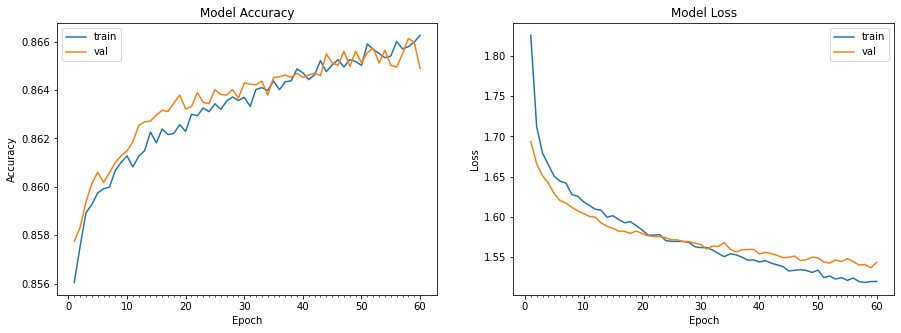

In [18]:
def plot_model_history(model_history, acc='accuracy', val_acc='val_accuracy'):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(range(1,len(model_history.history[acc])+1),model_history.history[acc])
    axs[0].plot(range(1,len(model_history.history[val_acc])+1),model_history.history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history[acc])+1),len(model_history.history[acc])/10)
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()
    
plot_model_history(history)

In [1]:
auc = history.history['auc']
val_auc = history.history['val_auc']
precision = history.history['precision']
val_precision = history.history['val_precision']

ax3.plot(range(1, len(auc) + 1), auc)
ax3.plot(range(1, len(val_auc) + 1), val_auc)
ax3.set_title('History of AUC')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('AUC')
ax3.legend(['training', 'validation'])

ax4.plot(range(1, len(precision) + 1), precision)
ax4.plot(range(1, len(val_precision) + 1), val_precision)
ax4.set_title('History of Precision')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('Precision')
ax4.legend(['training', 'validation'])

NameError: name 'history' is not defined

In [23]:
expression_dict = list(train_dataset.class_indices.keys())
expression_dict

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

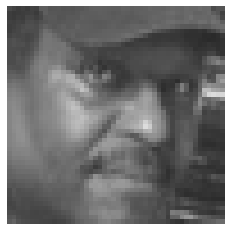

angry
[[0.29112548 0.02666723 0.08412883 0.18133357 0.15214276 0.2462433
  0.01835885]]


In [51]:
from keras.models import load_model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os


def load_image(img_path, show=True):

    img = image.load_img(img_path, target_size=(48,48))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor


# load model
loaded_model = load_model("model_vgg16.h5")

# image path
img_path = '../data/test/neutral/20.jpg'
#img_path = '/media/data/dogscats/test1/19.jpg'      # cat

# load a single image
new_image = load_image(img_path)

# check prediction
pred = loaded_model.predict(new_image)

predictions = list(pred[0])
expression_output = expression_dict[(predictions.index(max(predictions)))]

print(expression_output)
print(pred)